# Парсинг Федресурса
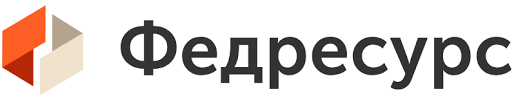

**Дисклеймер:** 

***Все данные на портале https://bankrot.fedresurs.ru/ находятся в открытом доступе в соответствии с Федеральным законом № 127-ФЗ "О несостоятельности(банкротстве)", любое их скачивание и демонстрирование не является правонарушением***

Целью данной тетрадки является демонстрация возможностей библиотеки Selenium на примере парсинга данных с портала Единого федерального реестра сведений о банкротстве "Федресурс"

In [1]:
%pip install selenium
%pip install pandas


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import re
import pandas as pd
from tqdm import tqdm

In [3]:
# Сделаем для примера список из 3х популярных имен
popular_names = ['Николай','Мария','Владимир']

# Запуск браузера (в данном случае, используем Chrome WebDriver)
# Не будем устанавливать режим headless для наглядности
driver = webdriver.Chrome()

# URL страницы делим на 2 части - чтобы удобно подставлять имена из списка в дальнейшем
url_base = 'https://bankrot.fedresurs.ru/bankrupts?searchString='
# limit=1000 означает вывод на экран 1000 записей
url_end = '&regionId=all&isActiveLegalCase=unknown&offset=0&limit=1000'

# Создадим пустые списки для каждого интересующего нас элемента
fio = []
address = []
status = []
case_number = []

for name in popular_names:
    # Для поиска каждого имени подставляем его в запрос
    url = url_base + name + url_end
    # Открываем страницу
    driver.get(url)
    # Ожидаем загрузки страницы
    wait = WebDriverWait(driver, 12)
    try:
        # По умолчанию, при открытии страницы открываются Юридические лица, нам же нужны Физические
        # Дожидаемся, когда элемент появится и станет кликабельным
        element = wait.until(EC.element_to_be_clickable((By.XPATH, "//span[contains(text(), 'Физические лица')]")))
        # Кликаем на "Физические лица"
        element.click()
        # Находим все элементы, которые соответствуют результатам поиска
        persons = driver.find_elements(By.CSS_SELECTOR, 'app-bankrupt-result-card-person')

        # Обернем в tqdm для отслеживания прогресса цикла по каждому имени
        for person in tqdm(persons, desc=f"Загрузка данных имени '{name}'"):
            # Загружаем данные в созданные списки
            try:                
                fio.append(person.find_element(By.CSS_SELECTOR, 'div.u-card-result__name > span').text)
            except:
                fio.append(None)
            try:
                address.append(person.find_element(By.CLASS_NAME, 'div.u-card-result__value.u-card-result__value_adr').text)
            except:
                try:
                    address.append(person.find_element(By.CSS_SELECTOR, 'div.u-card-result__addres > div.u-card-result__value').text)
                except:
                    address.append(None)
            try:
                status.append(person.find_element(By.CSS_SELECTOR, '.u-card-result__value.u-card-result__value_cursor-def.u-card-result__value_item-property.u-card-result__value_width-item').text)
            except:
                status.append(None)
            try:
                case_number.append(person.find_element(By.CSS_SELECTOR, '.u-card-result__court-case.u-card-result__court-case_mb')
                                         .find_element(By.CLASS_NAME, 'u-card-result__value').text)
            except:
                case_number.append(None)
    
    except:
        print(f"Элемент не найден или не может быть кликнут. Имя '{name}'")
    
# Закрытие браузера
driver.quit()


Загрузка данных имени 'Владимир': 100%|██████████| 1000/1000 [00:36<00:00, 27.51it/s]


In [4]:
# Сделаем из списков словарь для удобства переноса в датафрейм
person_data = {
    'fio': fio,
    'address': address,
    'status': status,
    'case_number': case_number
}
# Создадим датафрейм для визуализации
df = pd.DataFrame(person_data)
df.shape

(3000, 4)

In [5]:
# Посмотрим, что удалось скачать
df.head(8)

,fio,address,status,case_number
0,АГАПОВ НИКОЛАЙ АНДРЕЕВИЧ,"г. Москва, ул. Белореченская, д.19, кв.36",Реализация имущества,А40-39826/2022
1,Агурбаш Николай Георгиевич,"Московская область, город Пушкино, микрорайон ...",Реализация имущества,А40-96540/2019
2,Адмаев Николай Иванович,"404130,Волгоградская область,г.Волжский,о.Зеле...",Производство по делу завершено,А12-17325/2018
3,Аксенов Николай Михайлович,"Ростовская область, г. Ростов-на-Дону, ул. 6-я...",Производство по делу завершено,А53-2451/2022
4,АКУЛИЧ НИКОЛАЙ ПЕТРОВИЧ,"614065, г. Пермь, ул. Космонавта Беляева, д. 4...",Реализация имущества,А50-20110/2019
5,АЛАБУГИН НИКОЛАЙ АНДРЕЕВИЧ,"630010, г. Новосибирск, ул. Алмазная, д. 4",Реализация имущества,А45-36527/2022
6,АЛЕКСАКОВ НИКОЛАЙ ВАДИМОВИЧ,"Московская обл., р-н.Наро-Фоминский, гор.Апрел...",Производство по делу завершено,А41-12917/2019
7,АЛЕКСАНДРОВ НИКОЛАЙ АЛЕКСАНДРОВИЧ,"309290, Белгородская область, Шебекинский райо...",Производство по делу завершено,А08-1872/2017


Далее выберем несколько записей, для сбора сообщений, содержащихся в них

In [6]:
# Создаем пустой список для сохранения данных
data_list = []

# Снова запускаем драйвер
driver = webdriver.Chrome()

url_base = f'https://bankrot.fedresurs.ru/bankrupts?searchString='
urls_end = '&regionId=all&isActiveLegalCase=unknown&offset=0&limit=15'

# Открываем каждую ссылку и сохраняем содержимое страницы в словаре
for index, row in df.loc[2860:2865,].iterrows():
    # Строим URL для запроса по ФИО
    url = url_base + row['fio'] + url_end
    # Открываем страницу
    driver.get(url)

    # Ожидание загрузки страницы и обработки JavaScript
    wait = WebDriverWait(driver, 10)

    # Используем явное ожидание для поиска ссылки
    try:
        link = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, 'el-info-link a')))

        # Используем execute_script для клика на ссылку
        driver.execute_script("arguments[0].click();", link)

        # Переключаемся на открывшуюся страницу
        driver.switch_to.window(driver.window_handles[1])

        # Добавляем неявное ожидание до 6 секунд
        driver.implicitly_wait(6)

        # Найти элемент дата рождения на странице
        try:
            date_of_birth_element = driver.find_element(By.CSS_SELECTOR, '.mr-3')
            date_of_birth = date_of_birth_element.text
        except: date_of_birth = None
        # Находим все элементы с сообщениями на странице
        message_elements = driver.find_elements(By.CSS_SELECTOR, '.content .caption__text')
        # Находим все элементы с классом 'content'
        content_elements = driver.find_elements(By.CLASS_NAME, 'content')

        for i in range(len(message_elements)):
            try:
                message = message_elements[i].text
                # Находим первый элемент 'a' внутри текущего элемента 'content'
                link_element = content_elements[i].find_element(By.TAG_NAME, 'a')
                
                # Извлекаем ссылку (href) и текст из элемента 'a'
                link = link_element.get_attribute('href')
                text = link_element.text

                # Извлекаем номер и дату из сообщения
                match = re.search(r'№(\d+) от (\d+\.\d+\.\d+)', message)
                number_of_msg = match.group(1)
                date_of_msg = match.group(2)

                # Добавляем данные в data_list
                data_list.append([index, date_of_msg, number_of_msg, text, link])
            except: pass

        # Добавим дату рождения в исходный датафрейм df
        df.at[index, 'date_of_birth'] = date_of_birth

        # Закрываем вкладку и возвращаемся на исходную
        driver.close()
        driver.switch_to.window(driver.window_handles[0])
    except:pass

# Закрываем браузер
driver.quit()

In [7]:
# Создаем колонки для нового датафрейма
columns = ['id', 'date_of_msg', 'number_of_msg', 'text', 'link']

# Создаем датафрейм
messages_df = pd.DataFrame(data_list, columns=columns)
messages_df.head(8)

,id,date_of_msg,number_of_msg,text,link
0,2860,25.01.2022,355383,Финальный отчет,https://fedresurs.ru/bankruptreport/40D15125-7...
1,2860,25.01.2022,8080842,Сообщение о судебном акте,https://fedresurs.ru/bankruptmessage/D8E60D082...
2,2860,18.01.2022,8037193,Сообщение о наличии или об отсутствии признако...,https://fedresurs.ru/bankruptmessage/6E2253D88...
3,2860,12.01.2022,8003779,Сообщение о результатах проведения собрания кр...,https://fedresurs.ru/bankruptmessage/664AE1E06...
4,2860,01.12.2021,7777400,Сообщение о собрании кредиторов,https://fedresurs.ru/bankruptmessage/F8226DDA3...
5,2860,17.06.2021,6841224,Уведомление о получении требований кредитора,https://fedresurs.ru/bankruptmessage/112256937...
6,2860,31.05.2021,6744949,Уведомление о получении требований кредитора,https://fedresurs.ru/bankruptmessage/8FACFD606...
7,2860,20.05.2021,6686461,Сообщение о судебном акте,https://fedresurs.ru/bankruptmessage/E932B5E29...


Теперь, на примере сообщений о внесудебном банкротстве, вытащим размер задолженности

In [8]:
df_test = messages_df[messages_df['text'] == "Сообщение о возбуждении процедуры внесудебного банкротства гражданина"]

In [9]:
# Запускаем браузер
driver = webdriver.Chrome() 

# Создаем списки для данных
debts_list = []

for index, row in df_test.iterrows():
    # Открываем страницу с таблицей
    url = row['link']  # Укажите URL вашей страницы
    id = int(row['id'])
    driver.get(url)

    driver.implicitly_wait(4)

    # Находим таблицу monetary-obligations-table
    try:
        table = driver.find_element(By.TAG_NAME, 'monetary-obligations-table')

        # Получаем строки tr из tbody
        rows = table.find_elements(By.TAG_NAME, 'tr')
    

        # Обходим строки tr и получаем данные из нужных элементов td
        for row in rows:
            tds = row.find_elements(By.TAG_NAME, 'td')
            if len(tds) >= 3:
                creditor = tds[0].find_element(By.CLASS_NAME, 'mb-2').text
                total = tds[2].find_element(By.CLASS_NAME, 'mb-2').text.split('\n')[1]
                debt = tds[2].find_elements(By.CLASS_NAME, 'mb-2')[1].text.split('\n')[1]
                
                debts_list.append([id,creditor,total,debt])
    except: pass
    
    try:
        tables = driver.find_elements(By.TAG_NAME, 'obligatory-payments-table')

        for table in tables:
            # Получаем строки tr из tbody
            rows = table.find_elements(By.TAG_NAME, 'tr')
        

            # Обходим строки tr и получаем данные из нужных элементов td
            for row in rows:
                tds = row.find_elements(By.TAG_NAME, 'td')
                if len(tds) >= 3:
                    creditor = tds[0].text
                    total = tds[1].text
                    debt = tds[1].text
                    
                    debts_list.append([id,creditor,total,debt])
    except: pass
      
# Закрываем браузер
driver.quit()

In [10]:
columns = ['id', 'creditor', 'total', 'debt']
debts = pd.DataFrame(debts_list, columns=columns)

# Выводим DataFrame debts
debts.head(8)

,id,creditor,total,debt
0,2863,"ПАО ""Сбербанк""","364 716,51 ₽","364 715,51 ₽"
1,2863,"ПАО СК ""Росгосстрах""","65 098,39 ₽","65 098,39 ₽"
2,2863,Исполнительский сбор по 85218/20/59034-ИП от 2...,"1 000,00 ₽","1 000,00 ₽"
3,2863,Исполнительский сбор по 154899/20/59034-ИП от ...,"4 556,89 ₽","4 556,89 ₽"
4,2863,Исполнительский сбор по 39160/17/59004-ИП от 2...,"25 530,31 ₽","25 530,31 ₽"
5,2863,Исполнительский сбор по 20911/19/59034-ИП от 1...,"9 286,68 ₽","9 286,68 ₽"
6,2863,Транспортный налог,"24 003,87 ₽","24 003,87 ₽"
7,2865,"ООО ""Столичное АВД""","29 258,35 ₽","29 258,35 ₽"
